In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

seed(888)
pd.set_option('display.max_columns', None)

# 1 Load validation set

In [18]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("brain_test_validate.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("main_test_validate.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)

# 2 Preprocessing of validation set

## 2.1 Physical activity preprocessing

People excluded due to wear time < 8000 minutes: 1147
People with data quality good wear time: Yes    8411
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
People with data quality good calibration: Yes    8411
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


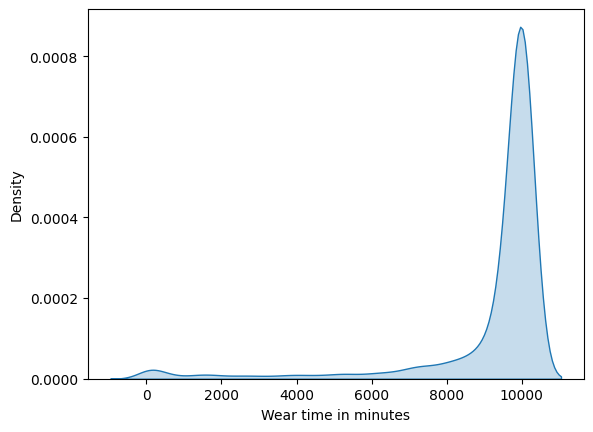

In [19]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print("People with data quality good wear time:", main_test.iloc[:,16650].value_counts())
print("People with data quality good calibration:", main_test.iloc[:,16651].value_counts())

In [20]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

# moderate + 2* vigorous PA -> weighten greater than moderate activity
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

## 2.2 BrainAge prediction for A2009 and All variables

In [21]:
nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 56
Number of people with missing brain values in test set: 25


### 2.2.1 A2009

In [22]:
X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

In [23]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

The MAE for cross-validation (Ridge): 4.171891275512917


In [24]:
# BrainAge model for testing data
# model trained on training tested on test
# model initialization - options to use Lasso, Ridge or SVM

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
# plt.figure()
# plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()


The MAE for testing set using Ridge: 4.205518522902305


In [25]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test


# plt.figure()
# plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
# plt.axline((65,65), slope=coef, color="g")
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.5271090464807392 30.46095098215246


### 2.2.2 All Variables

In [26]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)
#print(X_train_std)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000, tol=1e-2)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)


coeff = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeff)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# # get mean absolute error (MAE)
# print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
# print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
# print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))



# plt.figure()
# plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

The MAE for cross-validation (Ridge): 3.1413795478076016
Index(['greywhite_contrast_in_precuneus_right_hemisphere_f27048_2_0',
       'volume_of_subcortgray_whole_brain_f26517_2_0',
       'volume_of_midbrain_whole_brain_f26719_2_0',
       'volume_of_vlp_left_hemisphere_f26686_2_0',
       'greywhite_contrast_in_inferiorparietal_right_hemisphere_f27031_2_0',
       'greywhite_contrast_in_precuneus_left_hemisphere_f27013_2_0',
       'volume_of_ventraldc_right_hemisphere_f26596_2_0',
       'volume_of_wholebrainstem_whole_brain_f26720_2_0',
       'volume_of_brainstem_whole_brain_f26526_2_0',
       'volume_of_pons_whole_brain_f26717_2_0'],
      dtype='object')
[0.76610333 0.86890552 0.88629637 0.89347537 0.91244725 0.9315584
 1.02270368 1.10614828 1.15628733 1.46133824]


In [27]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred_Ridge)
corr_brainage_delta_4 = corr_brainage_4-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_4))

# plt.figure()
# plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.7379896692727317 16.924652601689274
The MAE for testing set corrected: 3.6511671805909383


### 2.2.3 Add BrainAge Deltas to Dataframe

In [28]:
main_test["BADA2009"] = corr_brainage_delta_1
main_test["BADAll"] = corr_brainage_delta_4

## 2.3 Variable Selection

In [29]:
# same for full dataset without exclusions
main_test_crop = []
main_test_crop = pd.DataFrame(main_test_crop)

main_test_crop["Age"] = main_test["Age"]
main_test_crop["Gender"] = main_test.iloc[:,22]
main_test_crop["TPA"] = main_test["Total PA"]
main_test_crop["VPA"] = main_test["Vigorous PA"]
main_test_crop["MPA"] = main_test["Moderate PA"]
main_test_crop["MVPA"] = main_test["MVPA"]
main_test_crop["LPA"] = main_test["Light PA"]
main_test_crop["BMI"] = main_test.iloc[:,11580]
main_test_crop["ECGW"] = main_test.iloc[:, 5773]
main_test_crop["ECGHR"] = main_test.iloc[:, 5775]
main_test_crop["SRLPA"] = main_test.iloc[:,9989]
main_test_crop["SRMPA"] = main_test.iloc[:,9990]
main_test_crop["SRVPA"] = main_test.iloc[:,9991]
main_test_crop["FI"] = main_test.iloc[:,9052]
main_test_crop["HGL"] = main_test.iloc[:,64]
main_test_crop["HGR"] = main_test.iloc[:,68]
main_test_crop["IS"] = main_test['uk_biobank_assessment_centre_f54_2_0']
main_test_crop["Smoking"] = main_test.iloc[:,650]
main_test_crop["SES"] = main_test.iloc[:,456]
main_test_crop["HR"] = main_test.iloc[:,10079]
main_test_crop["JPA"] = main_test.iloc[:,507]
main_test_crop["DBP"] = main_test.iloc[:,1551]
main_test_crop["SBP"] = main_test.iloc[:,1559]
main_test_crop["WS"] = main_test.iloc[:,542]
main_test_crop["BADA2009"] = main_test["BADA2009"]
main_test_crop["BADAll"] = main_test["BADAll"]

main_test = main_test_crop

## 2.4 Recoding

In [30]:
# 1 = Cheadle;  2 = Reading;  3 = Newcastle;  4 = Bristol
main_test['IS'] = main_test['IS'].map({'11025': 1, '11026': 2,'11027': 3, '11028': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["JPA"] = main_test["JPA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["WS"] = main_test["WS"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})


main_test = main_test.rename(columns={"BADA2009": "BA"})

main_test = pd.DataFrame(main_test)

# 3 Basic distributions of validation set

## 3.1 Data

In [31]:
main_test.head()

,Age,Gender,TPA,VPA,MPA,MVPA,LPA,BMI,ECGW,ECGHR,SRLPA,SRMPA,SRVPA,FI,HGL,HGR,IS,Smoking,SES,HR,JPA,DBP,SBP,WS,BA,BADAll
24945,65.0,1,1474.0416,18.0864,198.9504,235.1232,1257.0048,28.9,NaN,NaN,412.5,80.0,0.0,7.0,49.0,40.0,1,0.0,-2.27794,NaN,0.0,81.0,121.0,2.0,11.701333,2.768641
34655,61.0,1,2388.9600,50.4000,463.6800,564.4800,1874.8800,23.9,NaN,NaN,198.0,400.0,240.0,6.0,29.0,29.0,1,0.0,-3.79876,55.0,0.0,88.0,156.0,2.0,0.723749,-0.909526
21099,55.0,0,2246.7456,8.5104,272.3328,289.3536,1965.9024,44.5,NaN,NaN,1386.0,240.0,0.0,6.0,26.0,26.0,1,0.0,-1.96244,NaN,0.0,115.0,185.0,1.0,-2.275505,0.701082
23431,67.0,1,1854.7200,40.3200,413.2800,493.9200,1401.1200,25.1,NaN,NaN,396.0,320.0,960.0,6.0,36.0,19.0,1,0.0,-1.88219,54.0,NaN,85.0,148.0,2.0,2.084038,4.095267
24485,63.0,1,2093.7024,9.3888,281.6640,300.4416,1802.6496,41.0,120.0,112.0,264.0,300.0,160.0,8.0,56.0,46.0,1,0.0,-4.54202,60.0,0.0,83.0,151.0,2.0,7.612525,-0.668111


## 3.2 Age and BrainAge

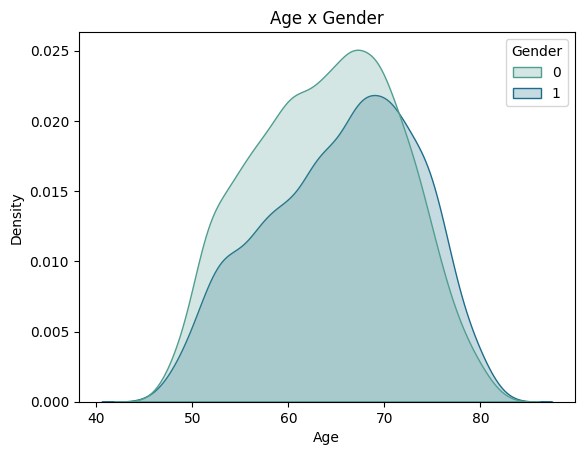

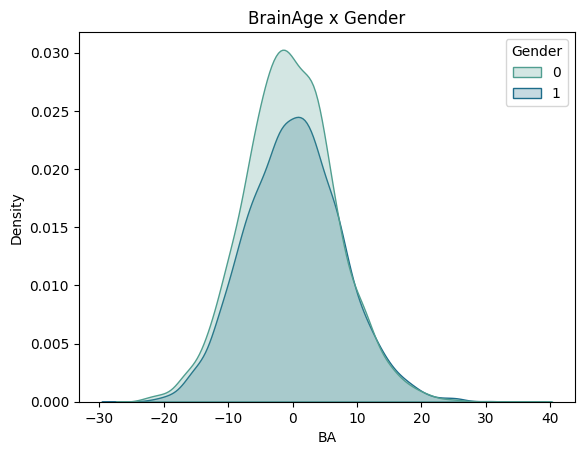

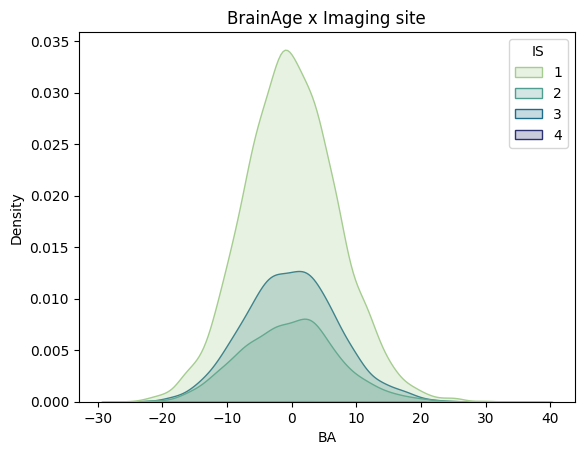

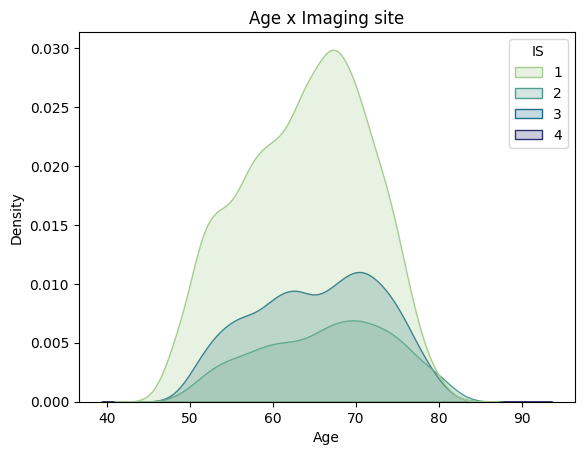

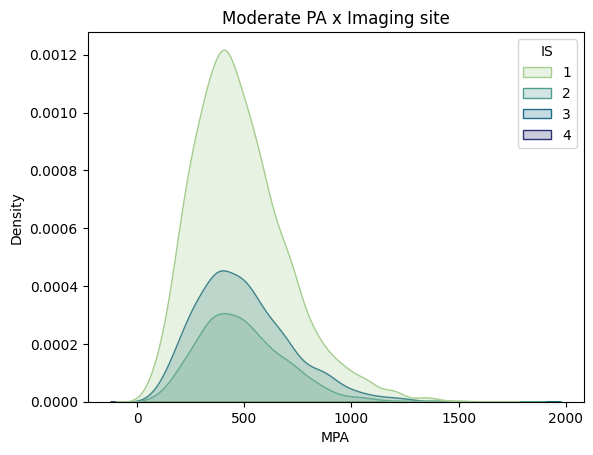

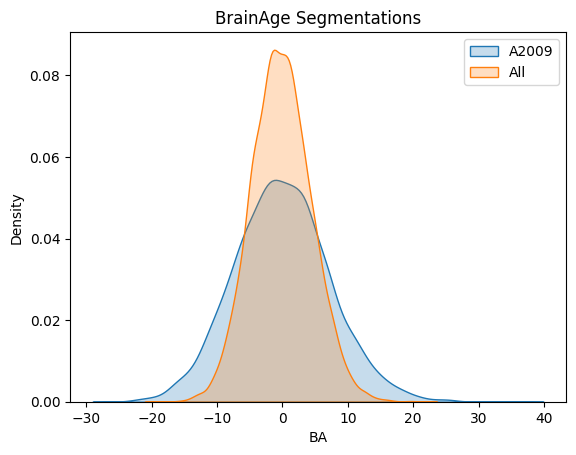

In [32]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'Gender', fill=True, palette = "crest")
plt.title("Age x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BA', hue = 'Gender', fill=True, palette = "crest")
plt.title("BrainAge x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BA', hue = 'IS', fill=True, palette = "crest")
plt.title("BrainAge x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'IS', fill=True, palette = "crest")
plt.title("Age x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'MPA', hue = 'IS', fill=True, palette = "crest")
plt.title("Moderate PA x Imaging site")
plt.show()


plt.figure()
sns.kdeplot(data = main_test, x= 'BA', fill=True, label="A2009")
sns.kdeplot(data = main_test, x= 'BADAll', fill=True, label="All")
plt.title("BrainAge Segmentations")
plt.legend()
plt.show()

## 3.3 Physical activity

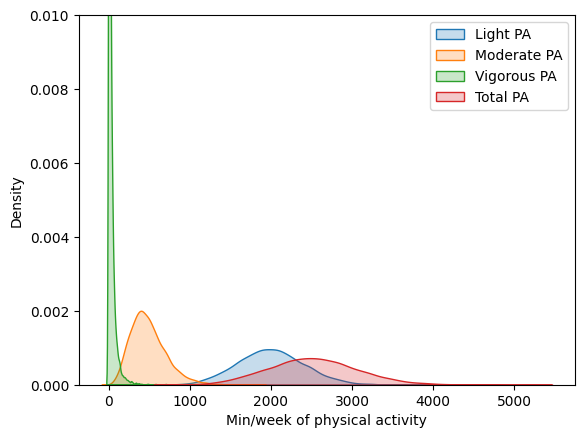

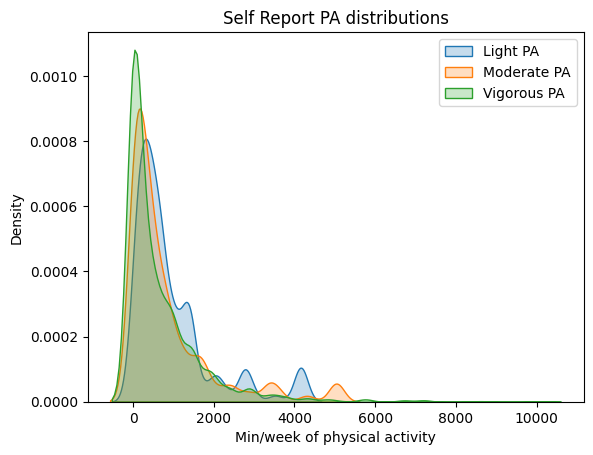

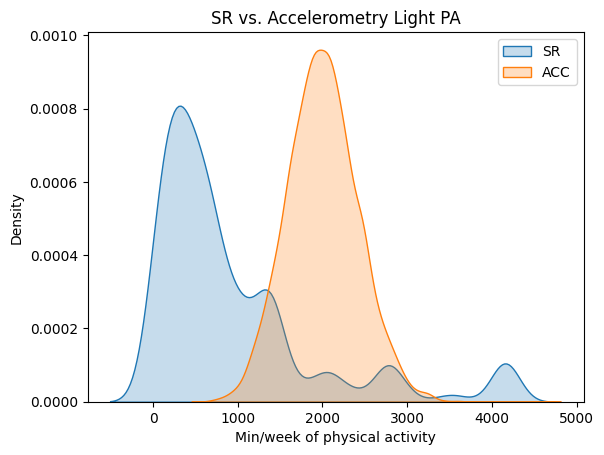

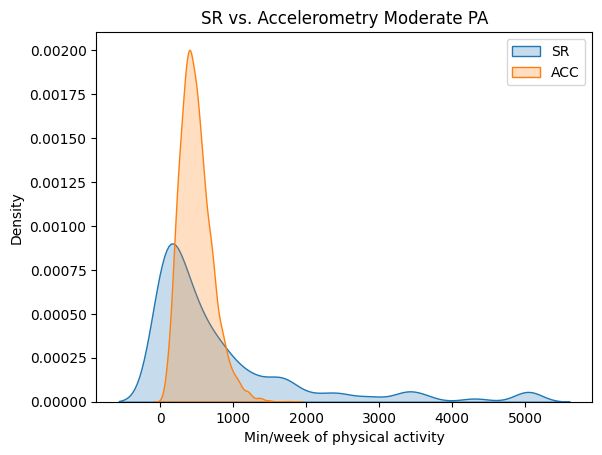

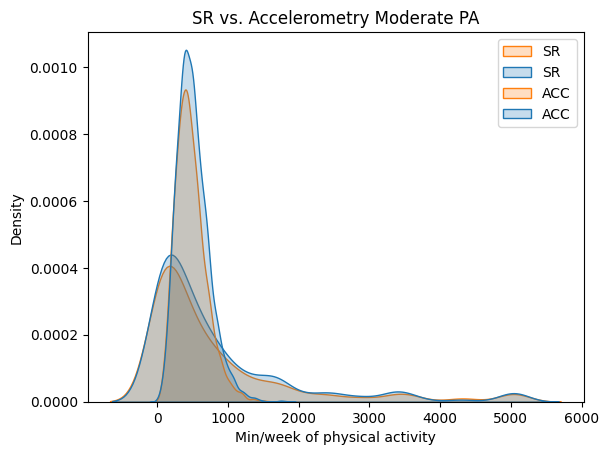

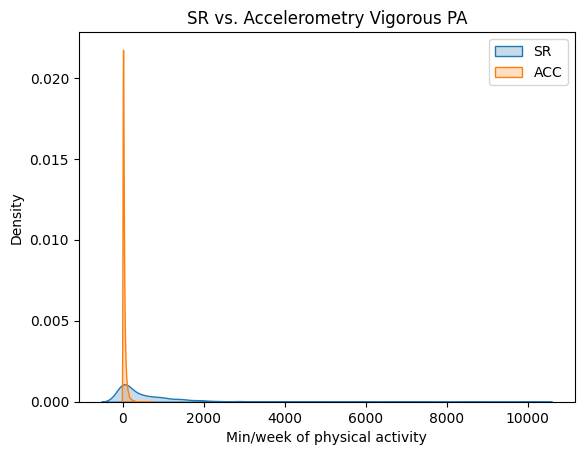

In [33]:
plt.figure()
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "Vigorous PA")
sns.kdeplot(data = main_test, x= 'TPA', fill=True, label = "Total PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.title("Self Report PA distributions")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Light PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', hue = "Gender", fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', hue = "Gender", fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Vigorous PA")
plt.legend()
plt.show()

## 3.4 Health and Fitness

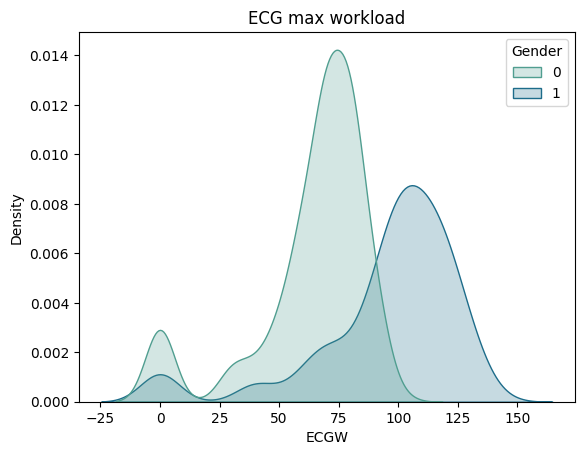

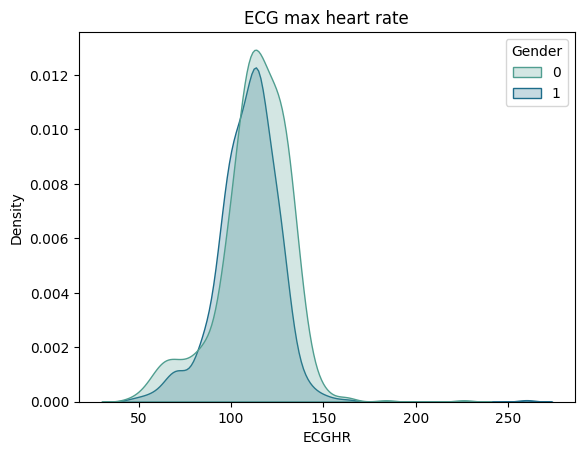

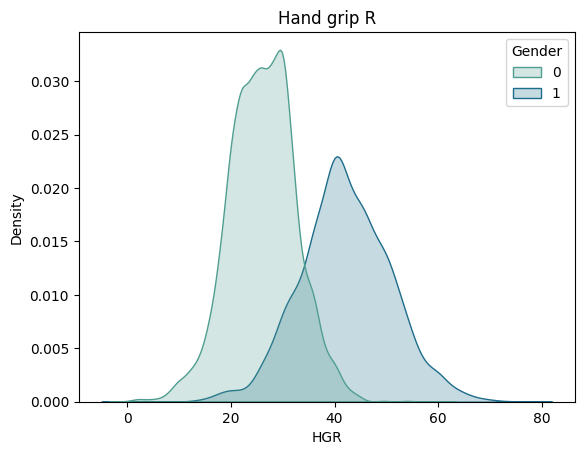

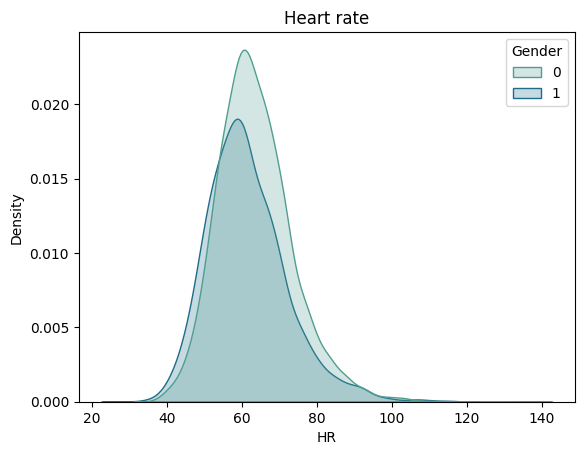

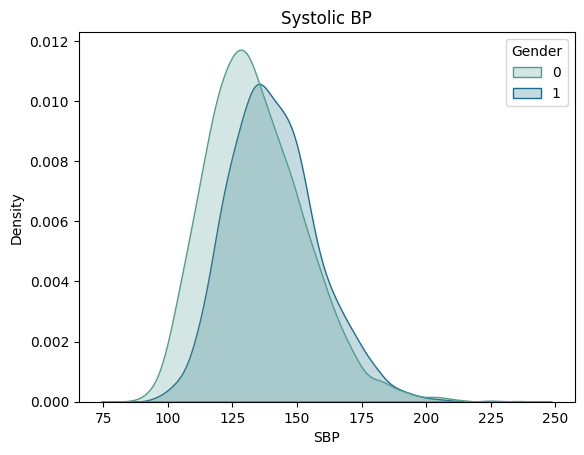

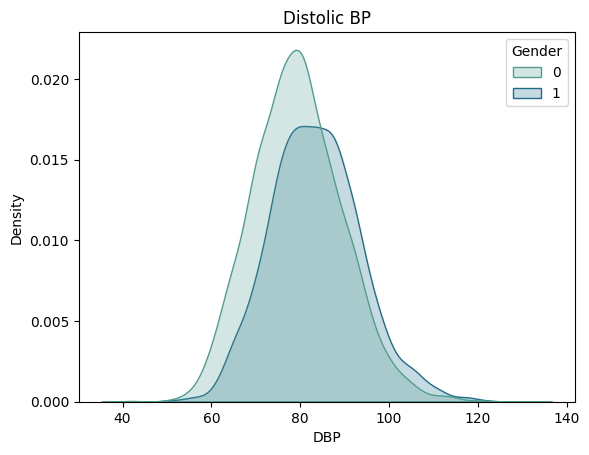

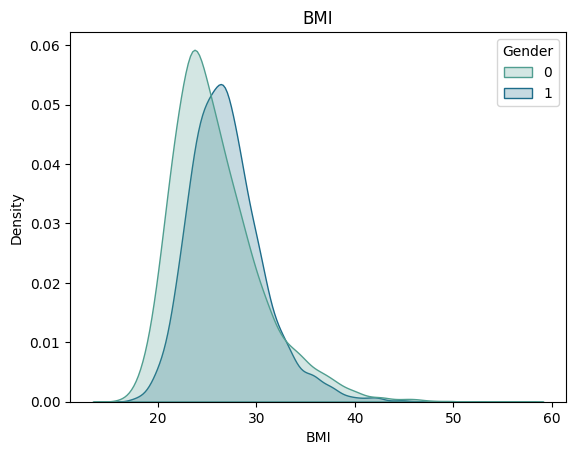

In [34]:
plt.figure()
sns.kdeplot(data = main_test, x= 'ECGW', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max workload")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'ECGHR', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HGR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Hand grip R")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Systolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'DBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Distolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BMI', hue = 'Gender', fill=True, palette = "crest")
plt.title("BMI")
plt.show()

# 4 Simple Correlation Heatmap

Text(0.5, 1.0, 'Correlations All')

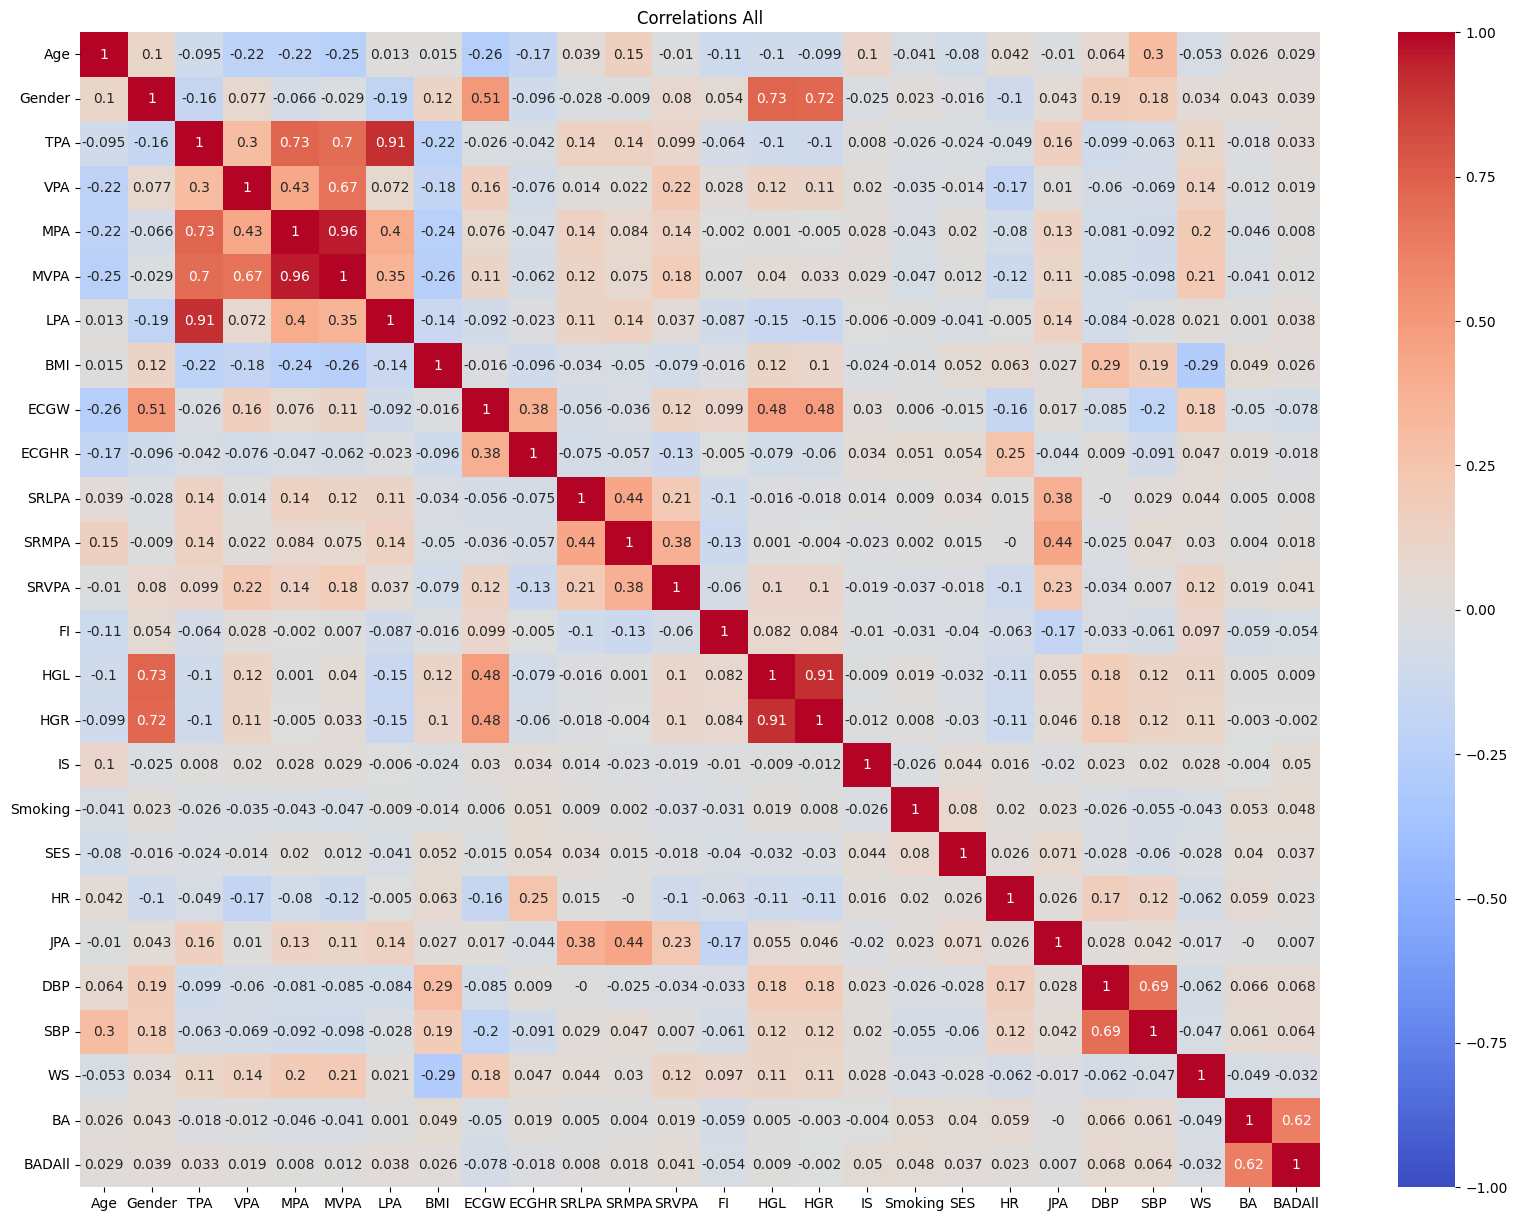

In [35]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# 5 Partial Correlations with Covariates

In [36]:
cov_correlation = pg.partial_corr(data=main_test, x='SRLPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRMPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRVPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='TPA', y='BA', covar=["Gender", "IS", "Age"])
print("Total PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='LPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='VPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate+Vigorous PA")
print(cov_correlation)

SR Light PA
            n         r          CI95%     p-val
pearson  7171  0.005811  [-0.02, 0.03]  0.622789
SR Moderate PA
            n        r          CI95%     p-val
pearson  7171  0.00179  [-0.02, 0.02]  0.879567
SR Vigorous PA
            n         r          CI95%     p-val
pearson  7171  0.015669  [-0.01, 0.04]  0.184702
Total PA
            n         r          CI95%     p-val
pearson  8386 -0.009572  [-0.03, 0.01]  0.380883
Light PA
            n        r          CI95%     p-val
pearson  8386  0.00897  [-0.01, 0.03]  0.411531
Moderate PA
            n        r           CI95%     p-val
pearson  8386 -0.03909  [-0.06, -0.02]  0.000344
Vigorous PA
            n         r          CI95%     p-val
pearson  8386 -0.010006  [-0.03, 0.01]  0.359649
Moderate+Vigorous PA
            n         r           CI95%     p-val
pearson  8386 -0.035457  [-0.06, -0.01]  0.001166


# 6 Models with OLS

## 6.1 Covariates

In [37]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

#calculate effect size
results = cov_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.142
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.94e-06
Time:                        12:08:17   Log-Likelihood:                -28557.
No. Observations:                8386   AIC:                         5.713e+04
Df Residuals:                    8379   BIC:                         5.718e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3101      1.604      2.063      0.0

## 6.2 Accelerometer PA

In [38]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

#calculate effect size
results = pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.236
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           7.98e-09
Time:                        12:08:17   Log-Likelihood:                -28547.
No. Observations:                8386   AIC:                         5.711e+04
Df Residuals:                    8376   BIC:                         5.718e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5900      1.660      2.162      0.0

## 6.3 Self-report PA

In [39]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())


#calculate effect size
results = sr_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.519
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           0.000232
Time:                        12:08:17   Log-Likelihood:                -24401.
No. Observations:                7171   AIC:                         4.882e+04
Df Residuals:                    7161   BIC:                         4.889e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6766      1.736      2.117      0.0

## 6.4 Accelerometer + Self-report PA

In [40]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())

#calculate effect size
results = sr_pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.464
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.48e-07
Time:                        12:08:18   Log-Likelihood:                -24390.
No. Observations:                7171   AIC:                         4.881e+04
Df Residuals:                    7158   BIC:                         4.890e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1437      1.795      2.308      0.0

## 6.5 Fitness

In [41]:
fitness = ols('BA ~ HGR + HGL + ECGW + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fitness.summary())

#calculate effect size
results = fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.966
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           5.16e-05
Time:                        12:08:18   Log-Likelihood:                -5012.8
No. Observations:                1473   AIC:                         1.005e+04
Df Residuals:                    1463   BIC:                         1.010e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1177      4.947      1.843      0.0

## 6.6 Health

In [42]:
health = ols('BA ~ ECGHR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(health.summary())

#calculate effect size
results = health
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8999
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.533
Time:                        12:08:18   Log-Likelihood:                -4187.2
No. Observations:                1231   AIC:                             8396.
Df Residuals:                    1220   BIC:                             8453.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3287      5.817     -0.916      0.3

## 6.7 Health and Fitness

In [43]:
he_fi = ols('BA ~ HGR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(he_fi.summary())

#calculate effect size
results = he_fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.73
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           2.75e-18
Time:                        12:08:18   Log-Likelihood:                -22463.
No. Observations:                6617   AIC:                         4.495e+04
Df Residuals:                    6606   BIC:                         4.502e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4644      1.972      1.250      0.2

## 6.8 Other variables

In [44]:
other = ols('BA ~ FI + Smoking + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(other.summary())

#calculate effect size
results = other
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.480
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.55e-11
Time:                        12:08:18   Log-Likelihood:                -20141.
No. Observations:                5924   AIC:                         4.030e+04
Df Residuals:                    5915   BIC:                         4.036e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5254      1.959      2.820      0.0

# 7 Model comparisons

## 7.1 Cov x PA

In [45]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0    8379.0  445528.758059      0.0          NaN       NaN       NaN
1    8376.0  444509.666529      3.0  1019.091529  6.400994  0.000251


In [46]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8379.0  445528.758059      0.0           NaN       NaN       NaN
1    7161.0  379072.337135   1218.0  66456.420923  1.030721  0.240998


## 7.2 Cov x PA x SR

In [47]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff     ss_diff         F    Pr(>F)
0    7161.0  379072.337135      0.0         NaN       NaN       NaN
1    7158.0  377920.342065      3.0  1151.99507  7.273121  0.000072


In [48]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0    8376.0  444509.666529      0.0           NaN       NaN       NaN
1    7158.0  377920.342065   1218.0  66589.324464  1.035497  0.209162


# 8 Mediation analysis

## 8.1 PA x Health / Fitness

### 8.1.1 BMI

In [49]:
#regression of x on m
model1 = ols('BMI ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ BMI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['BMI']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.0003876289475399487
Direct effect: -0.001113549779989901
Total effect: -0.0015011787275298497


### 8.1.2 DBP

In [50]:
#regression of x on m
model1 = ols('DBP ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ DBP',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['DBP']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00017383188259809522
Direct effect: -0.0013273468449317544
Total effect: -0.0015011787275298497


### 8.1.3 Heart rate

In [51]:
#regression of x on m
model1 = ols('HR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00015379903938006898
Direct effect: -0.0013473796881497808
Total effect: -0.0015011787275298497


## 8.2 SR PA x Job PA / Fluid intelligence

In [52]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 5.040433598857645e-05
Direct effect: -2.446356791791562e-05
Total effect: 2.5940768070660833e-05


In [53]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 5.040433598857645e-05
Direct effect: -2.446356791791562e-05
Total effect: 2.5940768070660833e-05


In [54]:
#regression of x on m
model1 = ols('FI ~ JPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ JPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['JPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['JPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.11367305714273947
Direct effect: -0.11579297601812386
Total effect: -0.002119918875384392
